In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
%matplotlib inline

# Comparing PIHA and TRINITITE
The tuples after each cluster name in the legend is `(Temperature, Initial Temperature)`. For a more in depth description see my notes on temperature ([here](../experiments/baseline/visualize/Notes.7-21-17.ipynb)). The TRINITITE cluster spits all results to 1 file, so we cannot tell who is doing the operations. The PIHA cluster has nodes named as: 

In [2]:
nodes = [("issdm-0", "splicer"),
         ("issdm-11", "workers"),
         ("issdm-12", "persistentDB"),
         ("issdm-15", "inmemoryDB"),
         ("issdm-18", "worker manager"),
         ("issdm-24", "workers"),
         ("issdm-27", "workers")]

## Times
These lines should be linear. One tool to make sure the system is healthy is the `times.out` file produced by ParSplice. The relationship between wall clock time and trajectory duration should be linear because it means the system is keeping up with the simulation load and is mirroring real time. According to Danny "In an ideal case, the trajectory length would proportional to the wall-clock time. Of course, seeing a linear trend alone does not tell you that you are running at the optimal simulation rate  (given by the slope), but usually a nice straight line means you are."

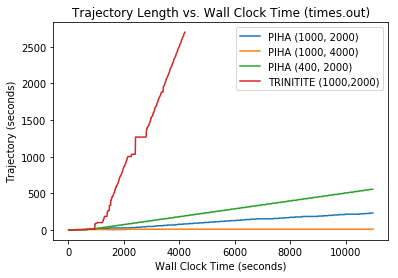

In [3]:
def plot_times(results, label):
    df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label)
    ax.set_ylabel("Trajectory (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

ax = plt.subplot(111)
ax.set_title("Trajectory Length vs. Wall Clock Time (times.out)")
plot_times("../experiments/baseline/results-parmsweep-keyspace/t1000it2000-rundev", "PIHA (1000, 2000)")
plot_times("../experiments/baseline/results-parmsweep-keyspace/t2000it4000-rundev", "PIHA (1000, 4000)")
plot_times("../experiments/baseline/results-parmsweep-keyspace/t400it2000-rundev", "PIHA (400, 2000)")
plot_times("../experiments/baseline-trinitite/", "TRINITITE (1000,2000)")

## Trajectories
The 0-column values in `traj.out` are states. If we plot these values sequentially along a uniform axis, we will get an idea of the molecules' location. Recall that the states are the locations that the molecules visit; state IDs are hashes of the DB key. The 1-column values in traj.out are the amount of time we have stayed in the state. Plotting these values along a summed axes gives us an idea of the locality. 

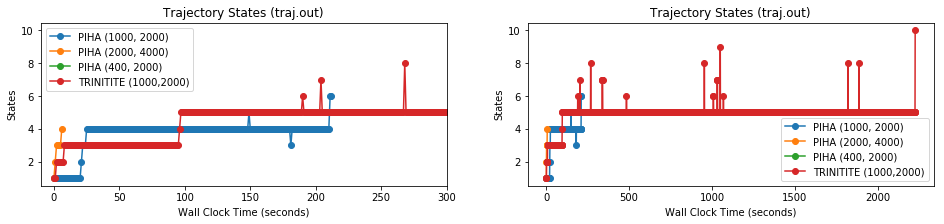

In [4]:
def plot_trajs(ax, results, label):
    # parse and find unique states
    df = pd.read_csv(results + "/traj.out", delimiter=" ", index_col=False, names=["space", "id", "len"])
    del df['space']    
    ids = pd.unique(df['id'].ravel())
    state = []
    for val in df['id']: 
        state.append(np.where(ids==val)[0][0])
    df['state'] = state
    
    # iterate to set x and y values
    x = []; y = []; i = 0
    for index, row in df.iterrows():
        for _ in range(0, row['len']):
            x.append(i)
            y.append(row['state'])
            i = i + 1
    ax.plot(x, y, label=label, marker='o')
    ax.set_title("Trajectory States (traj.out)")
    ax.set_ylabel("States")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()
    
fig, ax = plt.subplots(1, 2, figsize=(16, 3))
dirname = "../experiments/baseline/results-parmsweep-keyspace"
for i in range(0, 2):
    plot_trajs(ax[i], dirname + "/t1000it2000-rundev", "PIHA (1000, 2000)")
    plot_trajs(ax[i], dirname + "/t2000it4000-rundev", "PIHA (2000, 4000)")
    plot_trajs(ax[i], dirname + "/t400it2000-rundev", "PIHA (400, 2000)")
    plot_trajs(ax[i], "../experiments/baseline-trinitite/", "TRINITITE (1000,2000)")
x = ax[0].set_xlim(-10, 300)

# Spatial Locality

In [5]:
# input: ax = where to plot
# input: results = directory with results
# input: op = operation to pull out
# input: nodes = list of nodes
def plot_keyspace(ax, op, nodes, title, results, off=0.3): 
    max_keyspace = pd.DataFrame(columns=['key', 'count']) # keyspace of server w/ biggest keyspace
    shift = 0
    for node in nodes:
        
        # preprocess data      
        try: shutil.rmtree("tmp")
        except: pass
        tar = tarfile.open(results + "/" + node[0] + "/parsplice-logs.tar.gz")
        tar.extractall()
        tar.close() 
        os.system("cat tmp/parsplice-logs/p.* | grep Semantic > tmp/keyspace.log") # hack!
        
        # transform data frame and count # of unique keys
        df = pd.read_csv("tmp/keyspace.log", names=['NULL', 'time', 'op', 'dbkey', 'key'])
        d = df[(df['op'] == op)].groupby('key').size()
        d = d.reset_index()
        d.columns=['key', 'count']
        
        # plot it (break if we don't find any ops)
        if len(d) == 0: continue 
        ax.bar(np.arange(len(d['key']))+shift, d['count'], width=0.3, label=node[1])
        shift = shift + off
        
        # collect statistics (save off largest keyspace)
        if len(d['key']) > len(max_keyspace['key']): 
            max_keyspace = d 

    # graph post processing
    x = np.arange(len(max_keyspace['key']))
    ax.set_xticks(x)
    ax.set_xticklabels([])
    ax.set_xlabel("Key ID")
    #ax.set_xticklabels(keys, rotation=90)
    ax.set_xlim(0, len(max_keyspace['key']))
    ax.set_title(title)
    ax.legend()

    # statistics
    hk_idx = max_keyspace['count'].idxmax() # index of hottest key
    hotkey = max_keyspace.loc[hk_idx]       # row of the hottest key
    print title + ":\tnkeys=" + str(len(hotkey['key'])) + ", hottest key=" + str(hotkey[0]) + " (count=" + str(hotkey[1]) + ")"

def plot_trinitite_keyspace(ax, op, title, results): 
    # preprocess data    
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")            
    os.system("cat " + results + "/basic-psplice-* | grep Semantic > tmp/keyspace.log") # ouch!
    
    # transform data frame and count # of unique keys
    df = pd.read_csv("tmp/keyspace.log", names=['NULL', 'time', 'op', 'dbkey', 'key'])
    d = df[(df['op'] == op)].groupby('key').size()
    d = d.reset_index()
    d.columns=['key', 'count']
    
    # plot it (break if we don't find any ops)
    if len(d) == 0: return
    x = np.arange(len(d['key']))
    ax.bar(x, d['count'], width=0.3, label="splicer/DBs")
    ax.set_xticks(x)
    ax.set_xlabel("Key ID")
    ax.set_xticklabels([])    
    #ax.set_xticklabels(d['key'], rotation=90)
    ax.set_title(title)
    ax.legend()
    
    maxkey = d.loc[d['count'].idxmax()]
    print title + ":\tnkeys=" + str(len(d['key'])) + ", hottest key=" + str(maxkey[0]) + " (count=" + str(maxkey[1]) + ")"

## DB Memory Put

PIHA (1000, 2000):	nkeys=19, hottest key=1427101085272353039 (count=136)
PIHA (2000, 4000):	nkeys=18, hottest key=521239256620914701 (count=23)
PIHA (400, 2000):	nkeys=20, hottest key=11331559962432290834 (count=1)
TRINITITE (1000, 2000):	nkeys=57, hottest key=15078487755110697300 (count=546)


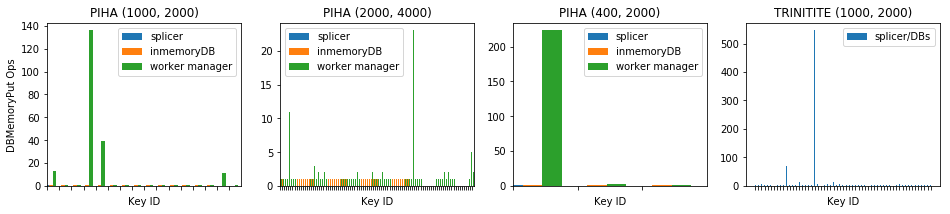

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
dirname = "../experiments/baseline/results-parmsweep-keyspace"
plot_keyspace(ax[0], "DBMemoryPut", nodes, "PIHA (1000, 2000)", dirname + "/t1000it2000-rundev")
plot_keyspace(ax[1], "DBMemoryPut", nodes, "PIHA (2000, 4000)", dirname + "/t2000it4000-rundev")
plot_keyspace(ax[2], "DBMemoryPut", nodes, "PIHA (400, 2000)",  dirname + "/t400it2000-rundev")
plot_trinitite_keyspace(ax[3], "DBMemoryPut", "TRINITITE (1000, 2000)", "../experiments/baseline-trinitite/")
x = ax[0].set_ylabel("DBMemoryPut Ops")

## DB Memory Get

PIHA (1000, 2000):	nkeys=19, hottest key=1427101085272353039 (count=183)
PIHA (2000, 4000):	nkeys=18, hottest key=521239256620914701 (count=64)
PIHA (400, 2000):	nkeys=2, hottest key=69 (count=2)
TRINITITE (1000, 2000):	nkeys=57, hottest key=15078487755110697300 (count=1063)


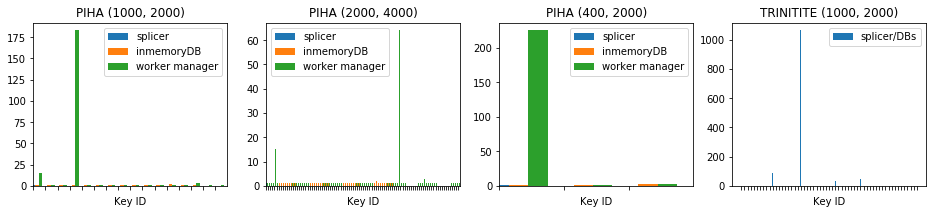

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
dirname = "../experiments/baseline/results-parmsweep-keyspace"
plot_keyspace(ax[0], "DBMemoryGet", nodes, "PIHA (1000, 2000)", dirname + "/t1000it2000-rundev")
plot_keyspace(ax[1], "DBMemoryGet", nodes, "PIHA (2000, 4000)", dirname + "/t2000it4000-rundev")
plot_keyspace(ax[2], "DBMemoryGet", nodes, "PIHA (400, 2000)",  dirname + "/t400it2000-rundev")
plot_trinitite_keyspace(ax[3], "DBMemoryGet", "TRINITITE (1000, 2000)", "../experiments/baseline-trinitite/")

PIHA (1000, 2000):	nkeys=20, hottest key=11331559962432290834 (count=1)
PIHA (2000, 4000):	nkeys=20, hottest key=11958820636485222800 (count=1)
PIHA (400, 2000):	nkeys=20, hottest key=11331559962432290834 (count=1)
TRINITITE (1000, 2000):	nkeys=54, hottest key=10172542120996291284 (count=1)


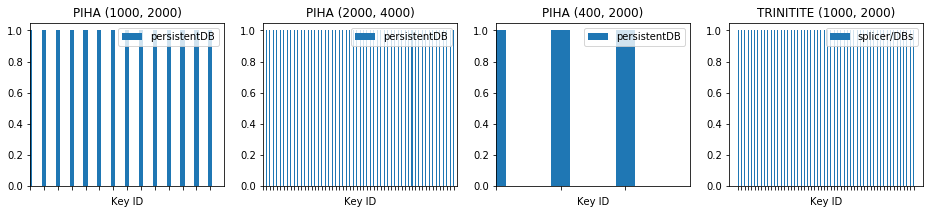

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
dirname = "../experiments/baseline/results-parmsweep-keyspace"
plot_keyspace(ax[0], "LDBPut", nodes, "PIHA (1000, 2000)", dirname + "/t1000it2000-rundev")
plot_keyspace(ax[1], "LDBPut", nodes, "PIHA (2000, 4000)", dirname + "/t2000it4000-rundev")
plot_keyspace(ax[2], "LDBPut", nodes, "PIHA (400, 2000)",  dirname + "/t400it2000-rundev")
plot_trinitite_keyspace(ax[3], "LDBPut", "TRINITITE (1000, 2000)", "../experiments/baseline-trinitite/")

PIHA (1000, 2000):	nkeys=2, hottest key=69 (count=1)
PIHA (2000, 4000):	nkeys=2, hottest key=69 (count=1)
PIHA (400, 2000):	nkeys=2, hottest key=69 (count=1)


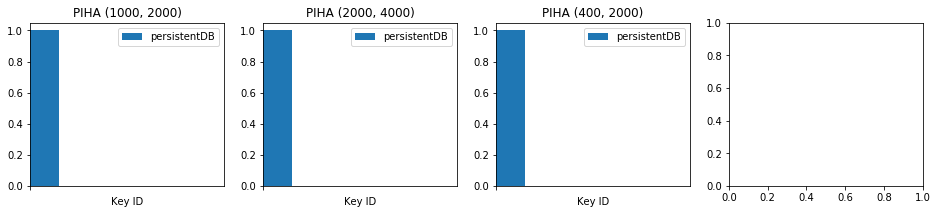

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
dirname = "../experiments/baseline/results-parmsweep-keyspace"
plot_keyspace(ax[0], "LDBGet", nodes, "PIHA (1000, 2000)", dirname + "/t1000it2000-rundev")
plot_keyspace(ax[1], "LDBGet", nodes, "PIHA (2000, 4000)", dirname + "/t2000it4000-rundev")
plot_keyspace(ax[2], "LDBGet", nodes, "PIHA (400, 2000)",  dirname + "/t400it2000-rundev")
plot_trinitite_keyspace(ax[3], "LDBGet", "TRINITITE (1000, 2000)", "../experiments/baseline-trinitite/")

# Temporal Locality

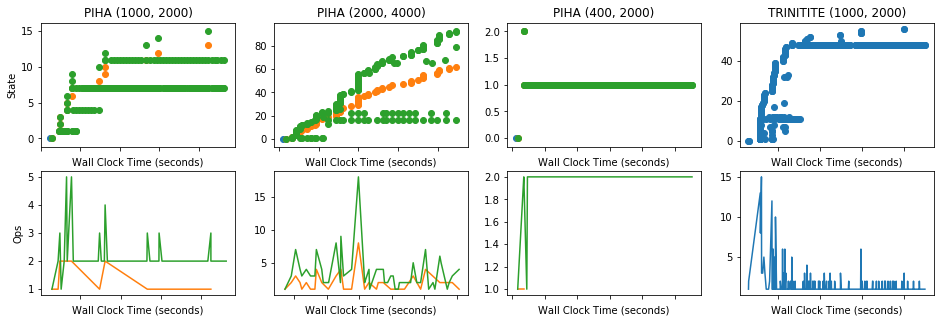

In [10]:
# input: ax = where to plot
# input: results = directory with results
# input: op = operation to pull out
# input: nodes = list of nodes
def plot_keytimes(ax, ax2, op, nodes, title, results, off=0.3): 
    max_keyspace = pd.DataFrame(columns=['key', 'count']) # keyspace of server w/ biggest keyspace
    shift = 0 
    for node in nodes:
        
        # preprocess data      
        try: shutil.rmtree("tmp")
        except: pass
        tar = tarfile.open(results + "/" + node[0] + "/parsplice-logs.tar.gz")
        tar.extractall()
        tar.close() 
        os.system("cat tmp/parsplice-logs/p.* | grep Semantic > tmp/keyspace.log") # hack!
        
        # transform data frame and filter by op
        df = pd.read_csv("tmp/keyspace.log", names=['NULL', 'time', 'op', 'dbkey', 'key'])
        df = df[df['op'] == op]
        d = df.groupby('time').size()
        d = d.reset_index()
        d.columns=['time', 'count']        
        
        # plot keyspace on y1 and time series on y2 (break if we don't find any ops)
        if len(df) == 0: continue
        ids = pd.unique(df['key'].ravel())
        state = []
        for val in df['key']: 
            state.append(np.where(ids==val)[0][0])
        df['state'] = state
        ax.scatter(df['time'], df['state'], label=node[1])        
        ax2.plot(d['time'], d['count'])        
        
        # collect statistics (save off largest keyspace)
        if len(df['key']) > len(max_keyspace['key']): 
            max_keyspace = df
        #print title + ":\tunique ts=" + str(len(df['key'])) + ", hottest key=" + str(hotkey[0]) + " (count=" + str(hotkey[1]) + ")"
        
    ax.set_xticklabels([])
    ax2.set_xticklabels([])    
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax2.set_xlabel("Wall Clock Time (seconds)")    
    ax.set_title(title)

def plot_trinitite_keytimes(ax, ax2, op, title, results):
    # preprocess data    
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")            
    os.system("cat " + results + "/basic-psplice-* | grep Semantic > tmp/keyspace.log") # ouch!
    
    # transform data frame and count # of unique keys
    df = pd.read_csv("tmp/keyspace.log", names=['NULL', 'time', 'op', 'dbkey', 'key'])
    df = df[df['op'] == op]
    d = df.groupby('time').size()
    d = d.reset_index()
    d.columns=['time', 'count']        
        
    # plot keyspace on y1 and time series on y2 (break if we don't find any ops)
    if len(df) == 0: return
    ids = pd.unique(df['key'].ravel())
    state = []
    for val in df['key']: 
        state.append(np.where(ids==val)[0][0])
    df['state'] = state
    ax.scatter(df['time'], df['state'], label="splicer/DB")        
    ax2.plot(d['time'], d['count'])        

    ax.set_xticklabels([])
    ax2.set_xticklabels([])    
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax2.set_xlabel("Wall Clock Time (seconds)")    
    ax.set_title(title)
    
fig, ax = plt.subplots(2, 4, figsize=(16, 5))
dirname = "../experiments/baseline/results-parmsweep-keyspace"
plot_keytimes(ax[0][0], ax[1][0], "DBMemoryPut", nodes, "PIHA (1000, 2000)", dirname + "/t1000it2000-rundev")
plot_keytimes(ax[0][1], ax[1][1], "DBMemoryPut", nodes, "PIHA (2000, 4000)", dirname + "/t2000it4000-rundev")
plot_keytimes(ax[0][2], ax[1][2], "DBMemoryPut", nodes, "PIHA (400, 2000)", dirname + "/t400it2000-rundev")
plot_trinitite_keytimes(ax[0][3], ax[1][3], "DBMemoryPut", "TRINITITE (1000, 2000)", "../experiments/baseline-trinitite/")
x = ax[0][0].set_ylabel("State")
x = ax[1][0].set_ylabel("Ops")